In [1]:
!pip install datasets

from datasets import load_dataset

# Load the dataset from Hugging Face's dataset hub
ds = load_dataset('thainq107/ntc-scv')

  Using cached datasets-3.2.0-py3-none-any.whl.metadata (20 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.2.3-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached huggingface_hub-0.27.0-py3-none-any.whl.metadata (13 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-win_amd64.whl.metadata (2.1 kB)
  Using cached aiohappyeyeballs-2.4.4-py3-none-any.whl.metadata (6.1 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached attrs-24.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached datasets-3.2.0-py3-none-any.whl (480 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached huggingface_hub-0.27.0-py3-none-any.whl (450 kB)
   -------------------------------

c:\Users\quang\anaconda3\envs\aie_torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import re
import string

def preprocess_text(text):
    # Remove URLs (e.g., https://www.)
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r" ", text)

    # Remove HTML tags (e.g., <tag>)
    html_pattern = re.compile(r'<[^>]+>')
    text = html_pattern.sub(r" ", text)

    # Remove punctuation and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2"             # Macau flag
        u"\U0001F1F4"             # flags
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"  # enclosed characters
        u"\U0001F926-\U0001F937"  # gestures
        u"\u200d"                 # zero width joiner
        u"\u2640-\u2642"          # gender symbols
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # Normalize whitespace
    text = " ".join(text.split())

    # Lowercase the text
    text = text.lower()

    return text


In [3]:
!pip install -q torchtext==0.17.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.0+cu121 requires torch==2.1.0+cu121, but you have torch 2.2.2 which is incompatible.
torchvision 0.16.0+cu121 requires torch==2.1.0+cu121, but you have torch 2.2.2 which is incompatible.


In [6]:
# Install torchtext if not already installed
# !pip install -q torchtext==0.17.2 (install before importing torchtext)

# Function to yield tokens from sentences using a tokenizer
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

# Word-based tokenizer
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

# Build vocabulary
from torchtext.vocab import build_vocab_from_iterator

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(ds['train']['preprocessed_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

# Convert torchtext dataset
from torchtext.data.functional import to_map_style_dataset

def prepare_dataset(df):
    # Create an iterator for dataset: (encoded_sentence, label)
    for row in df:
        sentence = row['preprocessed_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

# Prepare datasets
train_dataset = prepare_dataset(ds['train'])
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(ds['valid'])
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(ds['test'])
test_dataset = to_map_style_dataset(test_dataset)


In [7]:
import torch

seq_length = 100

def collate_batch(batch):
    # Create inputs, offsets, and labels for batch
    sentences, labels = list(zip(*batch))
    encoded_sentences = [
        sentence + ([0] * (seq_length - len(sentence))) if len(sentence) < seq_length else sentence[:seq_length]
        for sentence in sentences
    ]

    encoded_sentences = torch.tensor(encoded_sentences, dtype=torch.int64)
    labels = torch.tensor(labels)

    return encoded_sentences, labels

from torch.utils.data import DataLoader

batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_batch
)

In [8]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = model(inputs)

        # Compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()

        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                f"| epoch {epoch:3d} | {idx:5d}/{len(train_dataloader):5d} batches "
                f"| accuracy {total_acc / total_count:8.3f}"
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss


def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [9]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []

    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()

        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f"/{model_name}.pt")

        times.append(time.time() - epoch_start_time)
        # Print metrics at the end of the epoch
        print("-" * 59)
        print(
            f"| End of epoch {epoch:3d} | Time: {time.time() - epoch_start_time:5.2f}s | Train Accuracy {train_acc:8.3f} | Train Loss {train_loss:8.3f} "
            f"| Valid Accuracy {eval_acc:8.3f} | Valid Loss {eval_loss:8.3f} "
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f"/{model_name}.pt"))
    model.eval()
    metrics = {
        "train_accuracy": train_accs,
        "train_loss": train_losses,
        "valid_accuracy": eval_accs,
        "valid_loss": eval_losses,
        "time": times,
    }
    return model, metrics

In [12]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))

    plt.figure()
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, eval_accs, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over Epochs")
    plt.show()

    plt.figure()
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, eval_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss over Epochs")
    plt.show()

In [14]:
import torch.nn as nn

In [19]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_dim))
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.device = device

    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        for layer in self.layers:
            x = layer(x)
        return x


In [20]:
class TransformerEncoderCls(nn.Module):
    def __init__(
        self, 
        vocab_size, 
        max_length, 
        num_layers, 
        embed_dim, 
        num_heads, 
        ff_dim, 
        dropout=0.1, 
        device='cpu'
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            vocab_size, embed_dim, max_length, num_layers, num_heads, ff_dim, dropout, device
        )
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=2)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.encoder(x)
        output = self.pooling(output.permute(0, 2, 1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.relu(output)
        output = self.fc2(output)
        return output


In [22]:
import os
import torch.optim as optim

In [24]:
# Hyperparameters
vocab_size = 10000
max_length = 100
embed_dim = 200
num_layers = 2
num_heads = 4
ff_dim = 128
dropout = 0.1

# Model initialization
model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout
)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TransformerEncoderCls(
    vocab_size, max_length, num_layers, embed_dim, num_heads, ff_dim, dropout, device
)
model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# Training setup
num_epochs = 10
save_model = './model'
os.makedirs(save_model, exist_ok=True)
model_name = 'model'

# Training the model
model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_dataloader, 
    valid_dataloader, num_epochs, device
)

| epoch   1 |    50/  235 batches | accuracy    0.490
| epoch   1 |   100/  235 batches | accuracy    0.515
| epoch   1 |   150/  235 batches | accuracy    0.535
| epoch   1 |   200/  235 batches | accuracy    0.535
-----------------------------------------------------------
| End of epoch   1 | Time: 104.59s | Train Accuracy    0.570 | Train Loss    0.691 | Valid Accuracy    0.668 | Valid Loss    0.685 
-----------------------------------------------------------
| epoch   2 |    50/  235 batches | accuracy    0.604
| epoch   2 |   100/  235 batches | accuracy    0.592
| epoch   2 |   150/  235 batches | accuracy    0.669
| epoch   2 |   200/  235 batches | accuracy    0.714
-----------------------------------------------------------
| End of epoch   2 | Time: 94.71s | Train Accuracy    0.735 | Train Loss    0.645 | Valid Accuracy    0.742 | Valid Loss    0.571 
-----------------------------------------------------------
| epoch   3 |    50/  235 batches | accuracy    0.756
| epoch   3

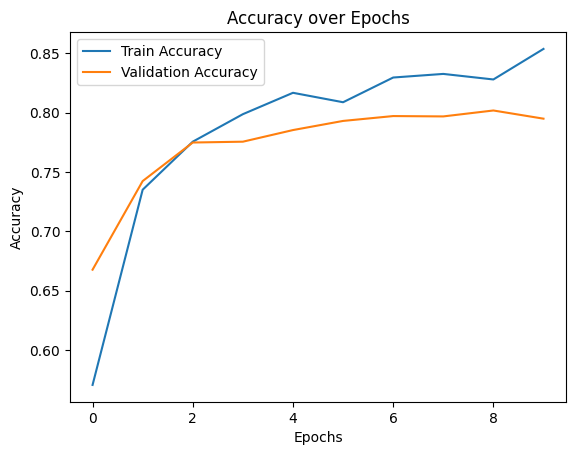

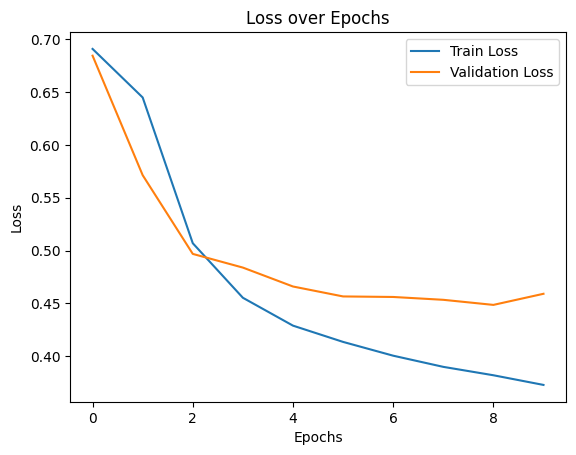

In [25]:
# Plotting the results
plot_result(num_epochs, metrics['train_accuracy'], metrics['valid_accuracy'], metrics['train_loss'], metrics['valid_loss'])